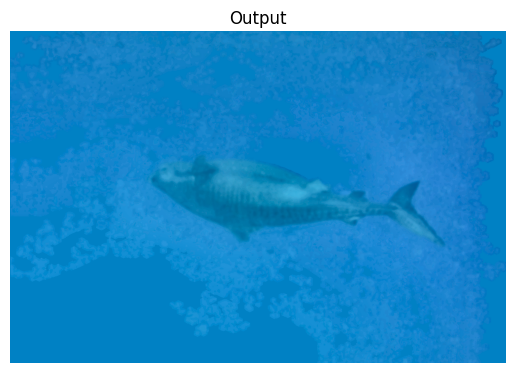

In [3]:
from pathlib import Path
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt

# PARAMS
INPUT_PATH = Path("/Users/aaronbaggot/Desktop/Image Processing/Image_Processing_Assignment_1/data/raw/Shark 1.PNG")   # change for Shark 2 or Shark 1
MODE   = "underwater"    # "underwater" or "silhouette"
ROTATE = True            # False for cat or diferent image
CLAHE_CLIP = 3.0
KSIZE      = 5
CLOSE_IT   = 1
DILATE_IT  = 2
PAD_FRAC   = 0.15



def enhance_image(I):
    """Enhance the image using bilateral filter, CLAHE, and sharpening."""
    den = cv.bilateralFilter(I, 7, 75, 75)
    L, A, B = cv.split(cv.cvtColor(den, cv.COLOR_BGR2LAB))
    L2 = cv.createCLAHE(clipLimit = CLAHE_CLIP, tileGridSize = (8,8)).apply(L)
    enh = cv.cvtColor(cv.merge([L2, A, B]), cv.COLOR_LAB2BGR)
    blur = cv.GaussianBlur(enh, (0,0), 1.0)
    enh = cv.addWeighted(enh, 1.20, blur, -0.20, 0)
    return enh

def segment_image(enh, mode):
    """Segment the image to create a mask based on mode."""
    if mode == "underwater":
        b = cv.cvtColor(enh, cv.COLOR_BGR2LAB)[:, :, 2]
        S = cv.cvtColor(enh, cv.COLOR_BGR2HSV)[:, :, 1]
        _, th_b = cv.threshold(b, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
        _, s_inv = cv.threshold(255 - S, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
        mask = cv.bitwise_and(th_b, s_inv)
        if (mask.sum()/255)/mask.size < 0.03:
            mask = cv.bitwise_or(th_b, s_inv)
    else:
        g = cv.cvtColor(enh, cv.COLOR_BGR2GRAY)
        gb = cv.GaussianBlur(g, (5,5), 0)
        inv = cv.normalize(255 - gb, None, 0, 255, cv.NORM_MINMAX)
        _, mask = cv.threshold(inv, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    return mask


def morph_mask(mask, ksize, close_it, dilate_it):
    """Apply morphological operations to the mask."""
    k = cv.getStructuringElement(cv.MORPH_ELLIPSE, (ksize, ksize))
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, k, iterations=close_it)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, k, iterations=1)
    if dilate_it > 0:
        mask = cv.dilate(mask, k, iterations=dilate_it)
    
    # Select largest component
    num, labc = cv.connectedComponents(mask)
    if num > 1:
        areas = [(labc == i).sum() for i in range(1, num)]
        mask = (labc == (1 + int(np.argmax(areas)))).astype(np.uint8) * 255
    
    return mask

def rotate_and_crop(enh, mask, rotate, pad_frac):
    """Rotate the image and mask if needed, then crop to bounding box with padding."""
    H, W = enh.shape[:2]
    if rotate:
        cnts, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        cnt = max(cnts, key=cv.contourArea)
        rect = cv.minAreaRect(cnt); angle = rect[-1]; (rw, rh) = rect[1]
        if rw < rh: angle += 90
        if angle < -45: angle += 90
        M = cv.getRotationMatrix2D((W//2, H//2), angle, 1.0)
        I_r = cv.warpAffine(enh, M, (W, H), flags = cv.INTER_LINEAR, borderMode = cv.BORDER_REFLECT)
        m_r = cv.warpAffine(mask, M, (W, H), flags = cv.INTER_NEAREST, borderMode = cv.BORDER_CONSTANT)
        cnt_t = cv.transform(cnt.reshape(-1,1,2).astype(np.float32), M).astype(np.int32)
        x, y, w, h = cv.boundingRect(cnt_t)
    else:
        cnts, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv.boundingRect(max(cnts, key = cv.contourArea))
        I_r, m_r = enh, mask
    
    pad = int(pad_frac * min(W, H))
    x0 = max(0, x - pad); y0 = max(0, y - pad)
    x1 = min(W, x + w + pad); y1 = min(H, y + h + pad)
    crop = I_r[y0:y1, x0:x1]
    mcrp = m_r[y0:y1, x0:x1]
    return crop, mcrp

def replace_background(crop, mcrp):
    """Replace background with median color from border pixels."""
    inv = (mcrp == 0).astype(np.uint8) * 255
    border = np.zeros_like(inv)
    border[:10, :] = 255; border[-10:, :] = 255
    border[:, :10] = 255; border[:, -10:] = 255
    samples = cv.bitwise_and(crop, crop, mask=cv.bitwise_and(inv, border)).reshape(-1, 3)
    samples = samples[(samples.sum(1) > 0)]
    bg = (210, 220, 230) if len(samples) == 0 else tuple(map(int, np.median(samples, 0)))
    canvas = np.full_like(crop, bg, dtype = np.uint8)
    final = cv.add(cv.bitwise_and(crop, crop, mask = mcrp),
                   cv.bitwise_and(canvas, canvas, mask = cv.bitwise_not(mcrp)))
    return final


def process_image(inp: Path):
    """Main processing function using modular steps."""
    I = cv.imread(str(inp), cv.IMREAD_COLOR)
    if I is None:
        raise FileNotFoundError(inp)
    
    enh = enhance_image(I)
    mask = segment_image(enh, MODE)
    mask = morph_mask(mask, KSIZE, CLOSE_IT, DILATE_IT)
    
    area = (mask.sum() / 255) / mask.size
    if area < 0.005 or area > 0.98:
        return enh
    
    crop, mcrp = rotate_and_crop(enh, mask, ROTATE, PAD_FRAC)
    final = replace_background(crop, mcrp)
    return final

   
# Run the processing
final_img = process_image(INPUT_PATH)
plt.imshow(cv.cvtColor(final_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Output")
plt.show()